In [ ]:
#IVF 350 删除外群
#随后在bash中运行如下命令
conda activate schicluster

#首先创建文件夹
for c in `seq 1 18`; do mkdir -p IVF350_cell_matrix_150k_rmOUTGROUP/chr${c}/; done
for c in `seq 1 18`; do mkdir -p IVF350_imputed_matrix_150k_rmOUTGROUP/chr${c}/; done
mkdir IVF350_imputed_matrix_150k_rmOUTGROUP/filelist/
mkdir -p IVF350_imputed_matrix_150k_rmOUTGROUP/merged/embed/

#下面的命令写在sh脚本里,用nohup运行，需要很长时间
cat IVF350_cell_list_rmOUTGROUP.txt |while read line; do for c in `seq 1 18`; do command time hicluster impute-cell --indir IVF350_cell_matrix_150k_rmOUTGROUP/chr${c}/ --outdir IVF350_imputed_matrix_150k_rmOUTGROUP/chr${c}/ --cell $line --chrom ${c} --res 150000 --chrom_file /home/lihaoxing/HiC-Pro-3.1.0/annotation/Sus_scrofa.chrom.schicluster.size; done; done

for c in `seq 1 18`; do awk -v c=$c '{printf("IVF350_imputed_matrix_150k_rmOUTGROUP/chr%s/%s_chr%s_pad1_std1_rp0.5_sqrtvc.hdf5\n",c,$1,c)}' IVF350_cell_type_rmOUTGROUP.txt > IVF350_imputed_matrix_150k_rmOUTGROUP/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt; echo $c; done

#下面的命令会报错`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_concatcell_chr.py中的np.str修改为str
for c in `seq 1 18`; do command time hicluster embed-concatcell-chr --cell_list IVF350_imputed_matrix_150k_rmOUTGROUP/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt --outprefix IVF350_imputed_matrix_150k_rmOUTGROUP/merged/embed/pad1_std1_rp0.5_sqrtvc_chr${c} --res 150000; done

ls IVF350_imputed_matrix_150k_rmOUTGROUP/merged/embed/*npy > IVF350_imputed_matrix_150k_rmOUTGROUP/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt

#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_mergechr.py 中的np.str修改为str
command time hicluster embed-mergechr --embed_list IVF350_imputed_matrix_150k_rmOUTGROUP/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt --outprefix IVF350_imputed_matrix_150k_rmOUTGROUP/merged/embed/pad1_std1_rp0.5_sqrtvc

2025-04-15 13:09:12.736475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 13:09:13.590025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4


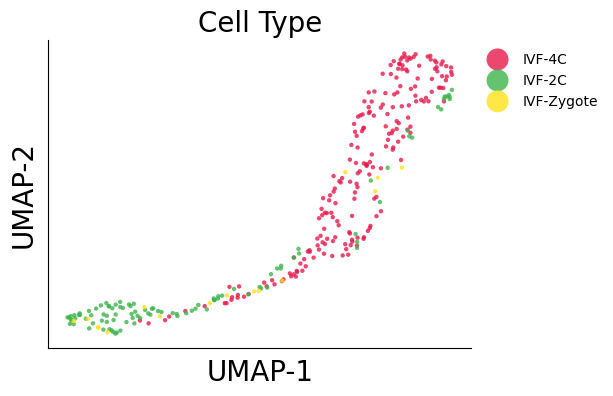

In [1]:
#IVF 325 150k 删除外群 2024年12月6日 最后一遍

import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans # 导入KMeans
from umap import UMAP
from itertools import cycle, islice
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'


color = np.array(list(islice(cycle(['#e6194b','#3cb44b','#ffe119']), 3)))


# load embedding
with h5py.File('/home/lihaoxing/try_scHiCluster/IVF350_imputed_matrix_150k_rmOUTGROUP/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# select dimension
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:,ndim], matrix_reduce[:,ndim+1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
#ndim可以自己调
ndim =6

umap = UMAP(n_neighbors=50,random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

label = pd.read_csv(f'/home/lihaoxing/try_scHiCluster/IVF350_cell_type_rmOUTGROUP.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# Save UMAP coordinates and labels to a CSV file
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
#umap_df['Cell_ID'] = label[0].values

umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('ivf300_150k_rmOUTGROUP_dim6_50.csv', index=True)

ds = 10
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.set_xlabel('UMAP-1', fontsize=20)
    ax.set_ylabel('UMAP-2', fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(['Cell Type', 'Cluster'][i], fontsize=20)

ax = axes[0]
for i, x in enumerate(label[1].value_counts().index):
    cell = (label[1] == x)
    ax.scatter(y[cell, 0], y[cell, 1], c=color[i], s=ds, edgecolors='none', alpha=0.8, label=x, rasterized=True)

ax.legend([ 'IVF-4C','IVF-2C', 'IVF-Zygote',], markerscale=5, prop={'size': 10}, bbox_to_anchor=(1, 1), loc='upper left', fontsize=20, frameon=False)

# Remove the second subplot
fig.delaxes(axes[1])

# 保存图片为 PDF
plt.savefig('IVF_150k_300cells_rmOUTGROUP_UMAP.svg', dpi=300, bbox_inches='tight', transparent=True)

4


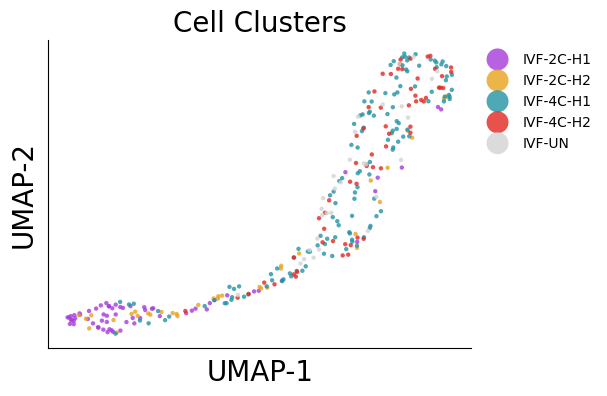

In [47]:
#IVF 325 150k 2 clusters

import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans # 导入KMeans
from umap import UMAP
from itertools import cycle, islice
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

color_mapping = {
    "IVF-2C-H1": "#A73BDD",
    "IVF-2C-H2": "#E7A31B",
    "IVF-4C-H1": "#2292A4",
    "IVF-4C-H2": "#E22720",
    "UN": "lightgrey"
}

# load embedding
with h5py.File('/home/lihaoxing/try_scHiCluster/IVF350_imputed_matrix_150k_rmOUTGROUP/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# select dimension
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:,ndim], matrix_reduce[:,ndim+1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
#ndim可以自己调
ndim =6

umap = UMAP(n_neighbors=50,random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

label = pd.read_csv(f'/home/lihaoxing/try_scHiCluster/IVF325_cell_type_TADcluster_rmOUTGROUP.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# Save UMAP coordinates and labels to a CSV file
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
#umap_df['Cell_ID'] = label[0].values

umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('ivf300_150k_dim6_50.csv', index=True)

ds = 10
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.set_xlabel('UMAP-1', fontsize=20)
    ax.set_ylabel('UMAP-2', fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(['Cell Clusters', 'Cluster'][i], fontsize=20)

ax = axes[0]
# Scatter plot of UMAP results colored by cell type
for cell_type, color in color_mapping.items():
    cell = (label[1] == cell_type)
    ax.scatter(y[cell, 0], y[cell, 1], c=color, s=ds, edgecolors='none', alpha=0.8, label=cell_type, rasterized=True)

ax.legend(['IVF-2C-H1', 'IVF-2C-H2', 'IVF-4C-H1', 'IVF-4C-H2', 'IVF-UN'], markerscale=5, prop={'size': 10}, bbox_to_anchor=(1, 1), loc='upper left', fontsize=20, frameon=False)

# Remove the second subplot
fig.delaxes(axes[1])

plt.savefig('IVF_300_UMAP_cluster2.svg', dpi=300, bbox_inches='tight', transparent=True)

In [6]:
#安装 py-monocle
!cd /home/lihaoxing/py-monocle
!pip install /home/lihaoxing/py-monocle

In [13]:
#Step 1: 准备输入数据
from py_monocle import learn_graph, order_cells, compute_cell_states

# 假设 y 是 UMAP 降维后的坐标，label['cluster'] 是聚类标签
umap = y
louvain = label['cluster'].values  # 或者你也可以换成其他聚类结果


In [37]:
import scanpy as sc
import anndata as ad
import numpy as np
from py_monocle import learn_graph

# Assuming `umap` is your N x 2 array from UMAP
adata = ad.AnnData(np.zeros((umap.shape[0], 0)))  # dummy expression
adata.obsm['X_umap'] = umap

# Step 1: build nearest neighbor graph
sc.pp.neighbors(adata, use_rep='X_umap', n_neighbors=15)

# Step 2: run Leiden clustering
sc.tl.leiden(adata, resolution=0.1)  # try different resolutions if needed
leiden_clusters = adata.obs['leiden'].astype(int).values  # convert to integers

In [38]:
#Step 2: 构建主图结构（principal graph）
projected_points, mst, centroids = learn_graph(matrix=umap, clusters=leiden_clusters)


In [39]:
#Step 3: 拟时序推断
# 这里 root_cells 设置为 0，也可以自己手动指定起始细胞索引
pseudotime = order_cells(
    umap,
    centroids,
    mst=mst,
    projected_points=projected_points,
    root_cells=0,
)


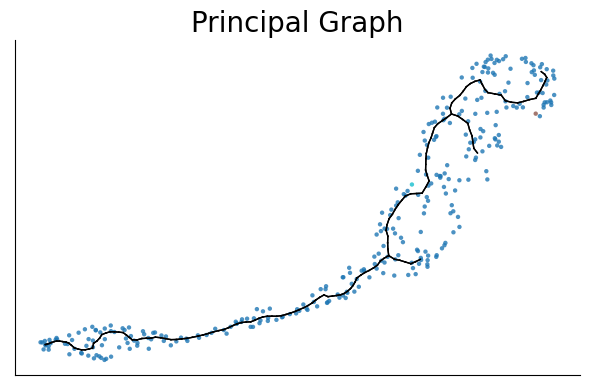

In [42]:
#Step 1: Principal Graph
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Principal Graph", fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# 画细胞点
scatter = ax.scatter(umap[:, 0], umap[:, 1], c=louvain, s=10, cmap="tab10", edgecolors='none', alpha=0.8, rasterized=True)

# 画graph边
for edge in edges:
    ax.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)

plt.tight_layout()
plt.savefig("Principal_Graph.svg", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


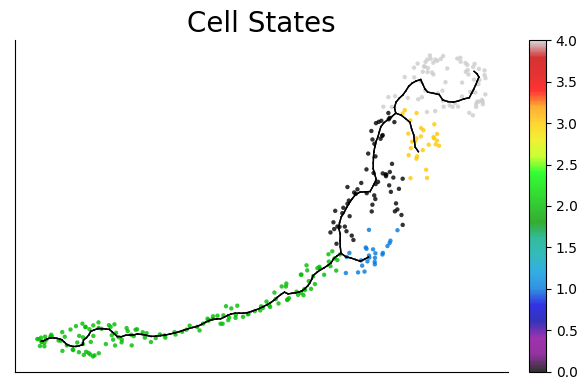

In [43]:
#Step 2: Cell States
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Cell States", fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

sc = ax.scatter(umap[:, 0], umap[:, 1], c=cell_states, s=10, cmap="nipy_spectral", edgecolors='none', alpha=0.8, rasterized=True)

for edge in edges:
    ax.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)

cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("Cell_States.svg", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


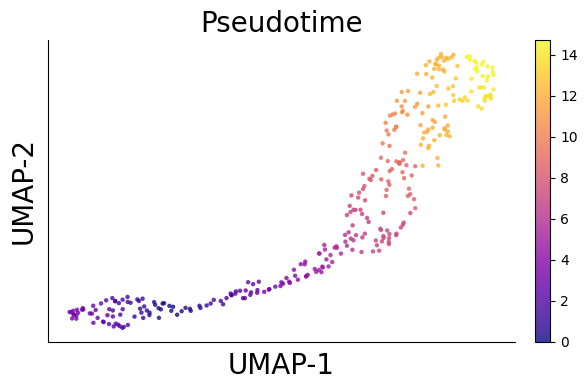

In [46]:
#Step 3: Pseudotime

from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Pseudotime", fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1', fontsize=20)
ax.set_ylabel('UMAP-2', fontsize=20)

sc = ax.scatter(umap[:, 0], umap[:, 1], c=pseudotime, s=10, cmap="plasma", edgecolors='none', alpha=0.8, rasterized=True)

cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig('IVF_300_Pseudotime.svg', dpi=300, bbox_inches='tight', transparent=True)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IVF-2C-C1 vs. IVF-2C-C2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.526e-01 U_stat=1.058e+03
IVF-4C-D1 vs. IVF-4C-D2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.672e-01 U_stat=3.885e+03


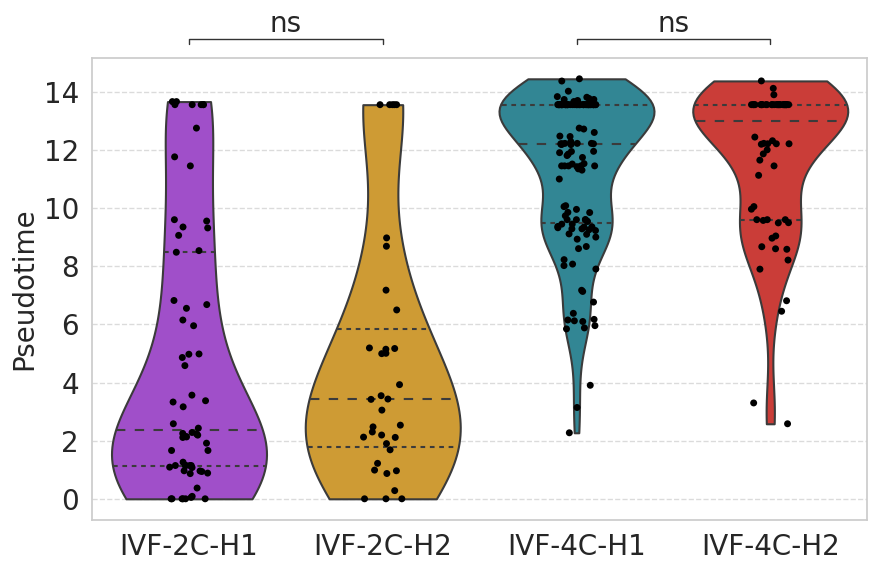

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

# 读取数据
data = pd.read_csv('IVF_TADcluster_time.txt', sep='\t')

# 设置绘图风格
sns.set(style="whitegrid")

# 自定义调色板
color_mapping = {
    "IVF-2C-C1": "#A73BDD",
    "IVF-2C-C2": "#E7A31B",
    "IVF-4C-D1": "#2292A4",
    "IVF-4C-D2": "#E22720",
    "UN": "lightgrey"
}
palette = [color_mapping[category] for category in data['type'].unique()]

# 绘制小提琴图
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='type', y='time', data=data, ax=ax, palette=palette, inner="quart", cut=0, scale="width")
sns.stripplot(x='type', y='time', data=data, color='black', size=5)

# 设置横坐标标签映射
label_mapping = {
    "IVF-2C-C1": "IVF-2C-H1",
    "IVF-2C-C2": "IVF-2C-H2",
    "IVF-4C-D1": "IVF-4C-H1",
    "IVF-4C-D2": "IVF-4C-H2",
}

# 更新横坐标标签
labels = [label_mapping.get(label, label) for label in data['type'].unique()]
ax.set_xticklabels(labels, fontsize=20)

# 对数据进行检验
pairs = [("IVF-2C-C1", "IVF-2C-C2"), ("IVF-4C-D1", "IVF-4C-D2")]

# 选择检验方法
chosen_test = 'Mann-Whitney'
annotator = Annotator(ax, pairs, data=data, x="type", y="time")
annotator.configure(test=chosen_test, text_format='star', line_height=0.01, line_width=1, loc='outside', fontsize=20)
annotator.apply_and_annotate()

# 添加网格线
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 设置图表标题和标签
plt.xlabel('')
plt.ylabel('Pseudotime', fontsize=20)
plt.yticks(fontsize=20)

# 再次确保横坐标标签设置正确
labels = [label_mapping.get(label, label) for label in data['type'].unique()]
ax.set_xticklabels(labels, fontsize=20)

plt.savefig('IVF_300_Pseudotime_clusters.svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
#2024.7.14更新
#用334再做一遍 150k 删除MII
#随后在bash中运行如下命令
conda activate schicluster
res=150000
ls /home/lihaoxing/150k_matrix_bed/334/* |awk -F '/' '{print$6}'|awk -F '_' '{print$1}' >334_cell_list.txt

#首先创建文件夹
for c in `seq 1 18`; do mkdir -p 334_imputed_matrix_150k_rmMII/chr${c}/; done
mkdir 334_imputed_matrix_150k_rmMII/filelist/
mkdir -p 334_imputed_matrix_150k_rmMII/merged/embed/

for c in `seq 1 18`; do awk -v c=$c '{printf("334_imputed_matrix_150k_rmMII/chr%s/%s_chr%s_pad1_std1_rp0.5_sqrtvc.hdf5\n",c,$1,c)}' 334_cell_type_rmMII.txt > 334_imputed_matrix_150k_rmMII/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt; echo $c; done

#下面的命令会报错`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_concatcell_chr.py中的np.str修改为str
for c in `seq 1 18`; do command time hicluster embed-concatcell-chr --cell_list 334_imputed_matrix_150k_rmMII/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt --outprefix 334_imputed_matrix_150k_rmMII/merged/embed/pad1_std1_rp0.5_sqrtvc_chr${c} --res 150000; done

ls 334_imputed_matrix_150k_rmMII/merged/embed/*npy > 334_imputed_matrix_150k_rmMII/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt

#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_mergechr.py 中的np.str修改为str
command time hicluster embed-mergechr --embed_list 334_imputed_matrix_150k_rmMII/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt --outprefix 334_imputed_matrix_150k_rmMII/merged/embed/pad1_std1_rp0.5_sqrtvc

6


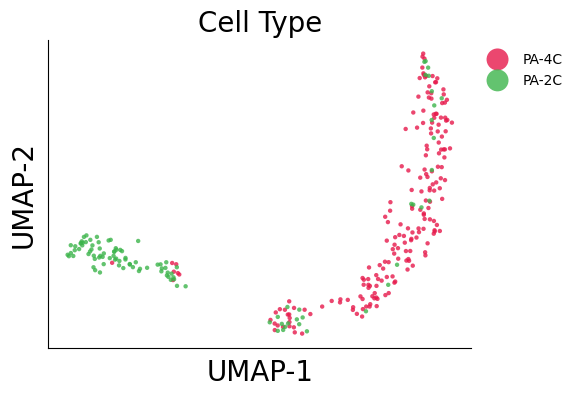

In [48]:
#PA 300cells 150k 删除MII 和外群 ，2024年12月6日 最后一遍

import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans # 导入KMeans
from umap import UMAP
from itertools import cycle, islice
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

color = np.array(list(islice(cycle(['#e6194b','#3cb44b','#ffe119','#0082c8','#f58231','#911eb4','#46f0f0','#f032e6','#d2f53c','#fabebe','#008080','#e6beff','#aa6e28','#800000','#aaffc3','#808000','#ffd8b1','#000080','#808080','#fffac8','#000000']), 100)))

# load embedding
with h5py.File('/home/lihaoxing/try_scHiCluster/334_imputed_matrix_150k_rmMII/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# select dimension
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:,ndim], matrix_reduce[:,ndim+1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
#ndim可以自己调
ndim =6

umap = UMAP(n_neighbors=80,random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

label = pd.read_csv(f'/home/lihaoxing/try_scHiCluster/334_cell_type_rmMII.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# Save UMAP coordinates and labels to a CSV file
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
#umap_df['Cell_ID'] = label[0].values

umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('PA_300cell_type_rmMII_150k_dim6_80.csv', index=True)

ds = 10
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.set_xlabel('UMAP-1', fontsize=20)
    ax.set_ylabel('UMAP-2', fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(['Cell Type', 'Cluster'][i], fontsize=20)

ax = axes[0]
for i, x in enumerate(label[1].value_counts().index):
    cell = (label[1] == x)
    ax.scatter(y[cell, 0], y[cell, 1], c=color[i], s=ds, edgecolors='none', alpha=0.8, label=x, rasterized=True)

#ax.legend(markerscale=5, prop={'size': 10}, bbox_to_anchor=(1, 1), loc='upper left', fontsize=20,frameon=False)
ax.legend(['PA-4C', 'PA-2C'], markerscale=5, prop={'size': 10}, bbox_to_anchor=(1, 1), loc='upper left', fontsize=20, frameon=False)

# Remove the second subplot
fig.delaxes(axes[1])

plt.savefig('PA_150k_300cells_rmMII_UMAP.svg', dpi=300, bbox_inches='tight', transparent=True)

6


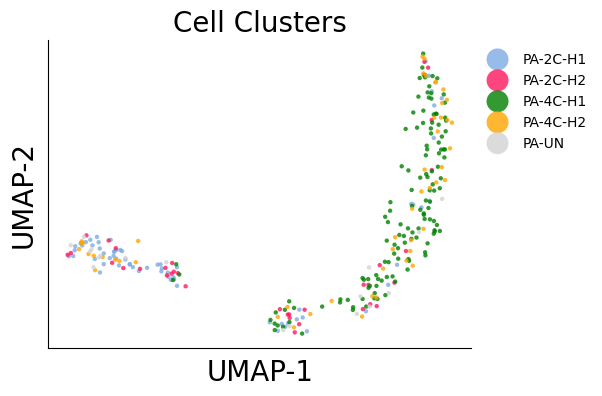

In [50]:
#PA 300cells 150k 删除MII 和外群 ，2024年12月6日 最后一遍

import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans # 导入KMeans
from umap import UMAP
from itertools import cycle, islice
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

color_mapping = {
    "PA-2C-H1": "#7dace4",
    "PA-2C-H2": "#ff165d",
    "PA-4C-H1": "green",
    "PA-4C-H2": "orange",
    "UN": "lightgrey"
}
# load embedding
with h5py.File('/home/lihaoxing/try_scHiCluster/334_imputed_matrix_150k_rmMII/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# select dimension
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:,ndim], matrix_reduce[:,ndim+1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
#ndim可以自己调
ndim =6

umap = UMAP(n_neighbors=80,random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

label = pd.read_csv(f'/home/lihaoxing/try_scHiCluster/PA300_cell_type_TADcluster_rmOUTGROUP.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# Save UMAP coordinates and labels to a CSV file
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
#umap_df['Cell_ID'] = label[0].values

umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('300cell_type_rmMII_150k_dim6_80.csv', index=True)

ds = 10
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.set_xlabel('UMAP-1', fontsize=20)
    ax.set_ylabel('UMAP-2', fontsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(['Cell Clusters', 'Cluster'][i], fontsize=20)

ax = axes[0]
# Scatter plot of UMAP results colored by cell type
for cell_type, color in color_mapping.items():
    cell = (label[1] == cell_type)
    ax.scatter(y[cell, 0], y[cell, 1], c=color, s=ds, edgecolors='none', alpha=0.8, label=cell_type, rasterized=True)

ax.legend(['PA-2C-H1', 'PA-2C-H2', 'PA-4C-H1', 'PA-4C-H2', 'PA-UN'], markerscale=5, prop={'size': 10}, bbox_to_anchor=(1, 1), loc='upper left', fontsize=20, frameon=False)

# Remove the second subplot
fig.delaxes(axes[1])

plt.savefig('PA_300cells_UMAP_cluster2.svg', dpi=300, bbox_inches='tight', transparent=True)

In [55]:
import scanpy as sc
import anndata as ad
from py_monocle import learn_graph, order_cells, compute_cell_states

# 创建 dummy 表达矩阵，只需要 UMAP 坐标即可
adata = ad.AnnData(np.zeros((y.shape[0], 0)))
adata.obsm['X_umap'] = y

# 计算邻接图
sc.pp.neighbors(adata, use_rep='X_umap', n_neighbors=15)

# 使用 Leiden 聚类（更适合 Monocle 风格的图结构学习）
sc.tl.leiden(adata, resolution=0.1)
leiden_clusters = adata.obs['leiden'].astype(int).values

projected_points, mst, centroids = learn_graph(matrix=y, clusters=leiden_clusters)

pseudotime = order_cells(
    y,
    centroids,
    mst=mst,
    projected_points=projected_points,
    root_cells=0  # 可以选择起始细胞，比如胚胎早期的
)


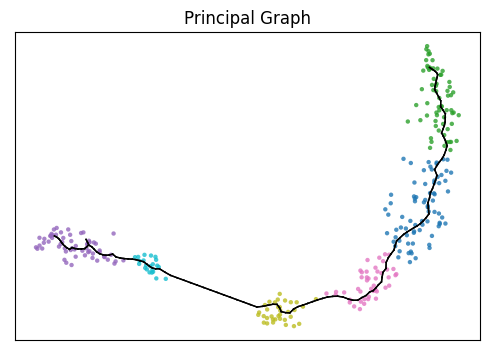

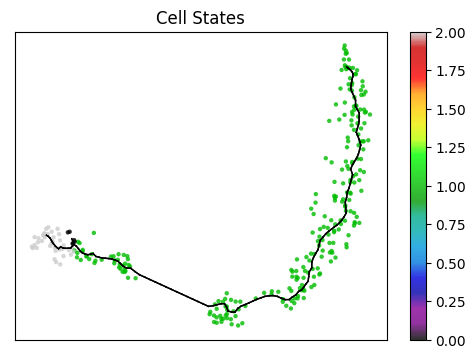

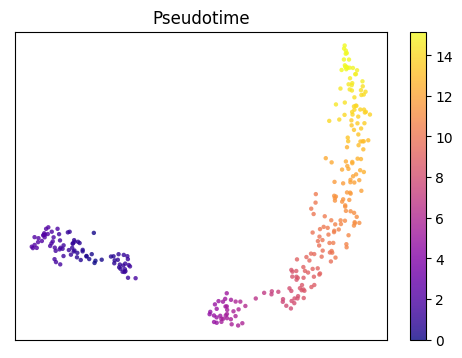

In [57]:
import matplotlib.pyplot as plt
import numpy as np

edges = np.array(mst.nonzero()).T
ds = 10

# 主图结构
plt.figure(figsize=(6, 4))
plt.title("Principal Graph")
plt.scatter(y[:, 0], y[:, 1], c=leiden_clusters, s=ds, cmap="tab10", edgecolors='none', alpha=0.8, rasterized=True)
for edge in edges:
    plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.xticks([]); plt.yticks([])
plt.savefig('PA_Principal_Graph.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# 细胞状态图
cell_states, _ = compute_cell_states(y, centroids, mst)
plt.figure(figsize=(6, 4))
plt.title("Cell States")
plt.scatter(y[:, 0], y[:, 1], c=cell_states, s=ds, cmap="nipy_spectral", edgecolors='none', alpha=0.8, rasterized=True)
for edge in edges:
    plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.colorbar()
plt.xticks([]); plt.yticks([])
plt.savefig('PA_Cell_States.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# 拟时序图
plt.figure(figsize=(6, 4))
plt.title("Pseudotime")
plt.scatter(y[:, 0], y[:, 1], c=pseudotime, s=ds, cmap="plasma", edgecolors='none', alpha=0.8, rasterized=True)
plt.colorbar()
plt.xticks([]); plt.yticks([])
plt.savefig('PA_Pseudotime.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


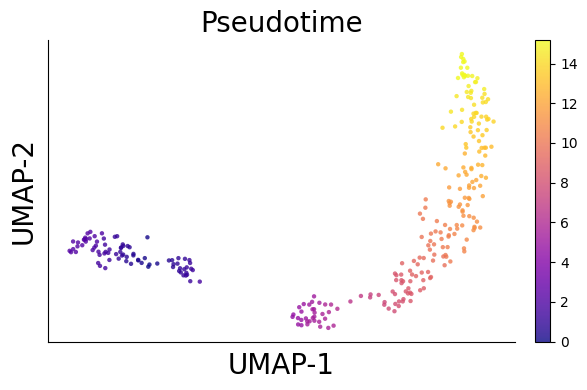

In [58]:
#Step 3: Pseudotime

from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Pseudotime", fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1', fontsize=20)
ax.set_ylabel('UMAP-2', fontsize=20)

sc = ax.scatter(umap[:, 0], umap[:, 1], c=pseudotime, s=10, cmap="plasma", edgecolors='none', alpha=0.8, rasterized=True)

cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig('PA_300_Pseudotime.svg', dpi=300, bbox_inches='tight', transparent=True)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PA-2C-A1 vs. PA-2C-A2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.931e-01 U_stat=1.267e+03
PA-4C-B1 vs. PA-4C-B2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.451e-01 U_stat=3.000e+03


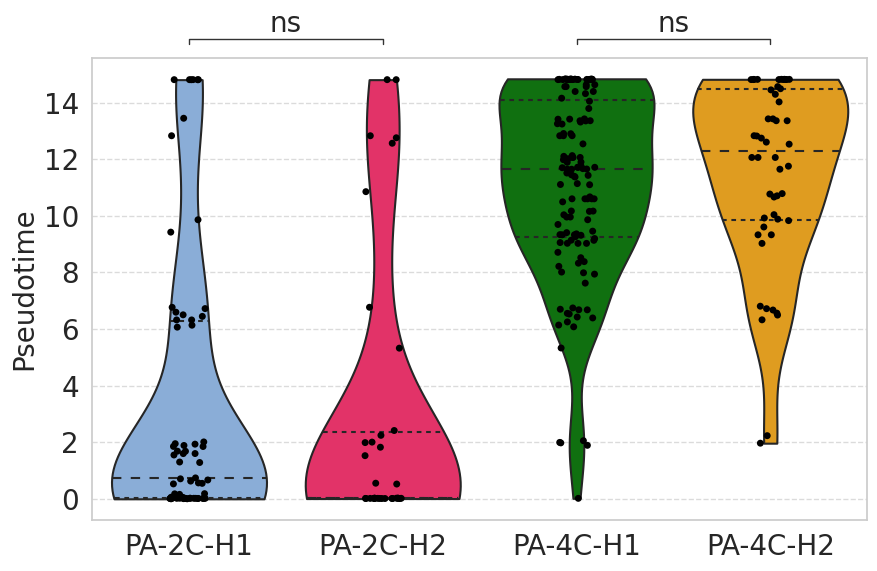

In [4]:
#PA tad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

# 读取数据
data = pd.read_csv('PA_TADcluster_time.txt', sep='\t')

# 设置绘图风格
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 自定义调色板
color_mapping = {
    "PA-2C-A1": "#7dace4",  # PA-2C-A1
    "PA-2C-A2": "#ff165d",  # PA-2C-A2
    "PA-4C-B1": "green",    # PA-4C-B1
    "PA-4C-B2": "orange",   # PA-4C-B2
    "UN": "lightgrey"
}
palette = [color_mapping[category] for category in data['type'].unique()]

# 绘制小提琴图
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='type', y='time', data=data, ax=ax, palette=palette, inner="quart", cut=0, scale="width")
sns.stripplot(x='type', y='time', data=data, color='black', size=5)

# 设置横坐标标签映射
label_mapping = {
    "PA-2C-A1": "PA-2C-H1",
    "PA-2C-A2": "PA-2C-H2",
    "PA-4C-B1": "PA-4C-H1",
    "PA-4C-B2": "PA-4C-H2",
}

# 更新横坐标标签
labels = [label_mapping.get(label, label) for label in data['type'].unique()]
ax.set_xticklabels(labels, fontsize=20)

# 对数据进行检验
pairs = [("PA-2C-A1", "PA-2C-A2"), ("PA-4C-B1", "PA-4C-B2")]

chosen_test = 'Mann-Whitney'
# 创建 Annotator 对象并应用检验
annotator = Annotator(ax, pairs, data=data, x="type", y="time")
annotator.configure(test=chosen_test, text_format='star', line_height=0.01, line_width=1, loc='outside', fontsize=20)
annotator.apply_and_annotate()

# 添加网格线
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 设置图表标题和标签
plt.xlabel('')
plt.ylabel('Pseudotime', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.savefig('PA_300_Pseudotime_clusters.svg', dpi=300, bbox_inches='tight', transparent=True)
